In [1]:
!git clone https://github.com/quentgar/dip-inpainting-registration
!mv dip-inpainting-registration/* ./

fatal: destination path 'dip-inpainting-registration' already exists and is not an empty directory.
mv: cannot stat 'dip-inpainting-registration/*': No such file or directory


In [2]:
pip install voxelmorph

In [3]:
from __future__ import print_function
import matplotlib.pyplot as plt
# %matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from src.utils import *
from src.hourglass_network import *
import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio

from voxelmorph.torch.layers import SpatialTransformer
import seaborn as sns

import cv2
from PIL import Image

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 32

In [4]:
img_path = 'mydata/video/city/'
mask_path = 'mydata/video/city/mask_phare/mask_'

ind_debut = 0
ind_fin = 19

img_path1 = img_path + "0" + str(ind_debut) + ".jpg"
mask_path1 = mask_path + "0" + str(ind_debut+1) + '.jpg'

img_np1 = format_image(img_path1, dim_div_by)
mask_np1 = format_image(mask_path1, dim_div_by)
size = img_np1.shape[1:]

In [5]:
# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var1 = np_to_torch(img_np1).type(dtype)
mask_var1 = np_to_torch(mask_np1).type(dtype)

#img_prec_var = net(net_input).detach().clone()
img_prec_var = img_var1

LR_inp = 0.001
LR_rec = 0.1


INPUT = 'noise'
input_depth = 32
num_iter = 2500
show_every = 100
figsize = 5
reg_noise_std = 0.03
depth = 5

Starting optimization with ADAM


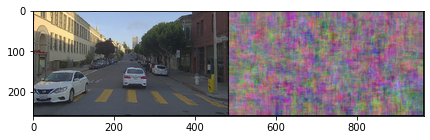

KeyboardInterrupt: ignored

In [6]:
for j in range(ind_debut+1, ind_fin+1):

  # Masque et image 2
  if j < 10:
      c = "0"
  else:
      c = ""

  img2_path = img_path + c + str(j) + '.jpg'
  mask2_path = mask_path + c + str(j) + '.jpg'

  img_np2 = format_image(img2_path, dim_div_by)
  mask_np2 = format_image(mask2_path, dim_div_by)
    
  # Création des réseaux 
  net_recalage = build_hourglass(input_depth, output_depth=2, 
            num_channels_down = [128]*depth,
            num_channels_up =   [128]*depth,
            num_channels_skip =    [4]*depth,  
            filter_size_up = 3, filter_size_down = 3, 
            up_samp_mode='nearest', filter_skip_size=1,num_scales=depth,need_sigmoid=False).type(dtype)

  net_inpainting = build_hourglass(input_depth, output_depth=img_np1.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [0]*depth,  
               filter_size_up = 5, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)

  net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)
  #net_input.div_(10)

  # Spatial transformer
  transformer = SpatialTransformer(size)

  # Création des tenseurs

  img_var2 = np_to_torch(img_np2).type(dtype)
  mask_var2 = np_to_torch(mask_np2).type(dtype)

  i = 0
  list_iter = []
  list_loss = []
  list_psnr = []
  best_loss = 10
  best_psnr = 0
  best_iter = 0
  best_out = None
  best_out_inp = None
  best_out_trans = None
  best_flow = None
  last_net_inp = None

  l1 = 1
  l2 = 3
  psnr_last = 0
    
  def closure():
      
      global i, list_iter, list_loss, list_psnr, inp_prec, flow_prec, best_loss, best_iter, best_out, best_flow, psnr_last, best_out_trans, best_out_inp, last_net_inp, best_psnr
      
      net_input = net_input_saved + (noise.normal_() * reg_noise_std)

      inp_prec = net_inpainting(net_input)
      flow_prec = net_recalage(net_input)
      
      out_trans = transformer(img_prec_var.type(torch.FloatTensor),flow_prec.type(torch.FloatTensor)).type(dtype)
    
      total_loss = l1*mse(out_trans, inp_prec) + l2*mse(inp_prec * mask_var2, img_var2 * mask_var2)
      total_loss.backward()
    
      psrn_gt = peak_signal_noise_ratio(img_np2 * mask_np2, inp_prec.detach().cpu().numpy()[0] * mask_np2)

      if best_psnr < psrn_gt :
        best_loss = total_loss.item()
        best_iter = i
        best_out_trans = out_trans
        best_out_inp = inp_prec
        best_flow = flow_prec
        best_psnr = psrn_gt
          
      if PLOT and i % show_every == 0:
          print ('Iteration %05d    Loss %f  image %d' % (i, total_loss.item(),j), '\r', end='')
          
          list_iter.append(i)
          list_loss.append(total_loss.item())
          list_psnr.append(psrn_gt)
          #plt.imshow(out_np.transpose(1,2,0))
          #plt.show()
          plot_image_grid([np.clip(torch_to_np(out_trans), 0, 1), np.clip(torch_to_np(inp_prec), 0, 1)], factor=5, nrow=2)
            
            
      # Backtracking
      if i % show_every == 0:
            if psrn_gt - psnr_last < -3: 
                print('Falling back to previous checkpoint.')

                for new_param, net_param in zip(last_net_inp, net_inpainting.parameters()):
                    net_param.data.copy_(new_param.cuda())

                i += 1

                return total_loss*0
            else:
                last_net_inp = [x.detach().cpu() for x in net_inpainting.parameters()]
                psnr_last = psrn_gt
        
          
      i += 1

      return total_loss

  net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()

  p1 = get_params(net_inpainting)
  p2 = get_params(net_recalage)

  optimize_joint(p1, p2, closure, LR_inp, LR_rec, num_iter)


  inp_prec2 = best_out_inp #net_inpainting(net_input)
  flow_prec2 = best_flow #net_recalage(net_input)
  #out_trans2 = transformer(img_prec_var.type(torch.FloatTensor),flow_prec2.type(torch.FloatTensor)).type(dtype)
  inp_prec2 = torch_to_np(inp_prec2)
  out_trans2 = torch_to_np(best_out_trans)
    
  img_prec_np2 = (inp_prec2 * mask_np2) + (out_trans2 * (1 - mask_np2))
  img_prec_var = np_to_torch(img_prec_np2)
  img_np = torch_to_np(img_prec_var)

  plt.figure()
  plt.plot(list_iter,list_psnr,linestyle='-')
  plt.title("PSNR en fonction du nombre d'itérations")
  plt.xlabel("Nombre d'itérations")
  plt.savefig("PSNR_" + str(j) + ".jpg")
  plt.show()

  t = img_np.transpose(1,2,0)*255
  im = Image.fromarray(t.astype(np.uint8))
  im.save('res/test_bestPSNR2/res'+str(j)+'.jpg')